In [1]:
# download movie lens 100k dataset
# !wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
# !pip install wget
# import wget
# url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
# filename = wget.download(url)
# !unzip ml-100k.zip
import pandas as pd
ratings = pd.read_csv(r'Dataset\ml-100k\u.data', sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings.drop('timestamp', axis=1, inplace=True)
ratings.head()


,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [2]:
#perform some preprocessing to encode users and movies as integer indices.

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
ratings['user_id'] = le.fit_transform(ratings['user_id'])
ratings['item_id'] = le.fit_transform(ratings['item_id'])


In [3]:
# prompt: Prepare training and validation data

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(ratings, test_size=0.2)
train_data.head()


,user_id,item_id,rating
51394,769,476,4
65453,552,131,4
79128,531,117,4
41692,536,22,4
81629,892,150,4


In [4]:
# num_users = len(train_data.user_id.unique())
# num_movies = len(train_data.item_id.unique())
num_users = max(train_data['user_id'].max(), test_data['user_id'].max()) + 1
num_movies = max(train_data['item_id'].max(), test_data['item_id'].max()) + 1
min_rating = train_data['rating'].min()
max_rating = train_data['rating'].max()
print("Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(num_users, num_movies, min_rating, max_rating) )


Number of users: 943, Number of Movies: 1682, Min rating: 1, Max rating: 5


In [5]:
# ! pip install tensorflow

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Flatten, Dot, Dense
from tensorflow.keras.models import Model

In [7]:
embedding_size = 64
user_input = tf.keras.Input(shape=(1,),name='user')
movie_input = tf.keras.Input(shape=(1,),name='movie')

In [8]:
user_embedding = Embedding(num_users, embedding_size)(user_input)
movie_embedding = Embedding(num_movies, embedding_size)(movie_input)

In [9]:
user_vec = Flatten()(user_embedding)
movie_vec = Flatten()(movie_embedding)

In [10]:
dot_product = Dot(axes=1)([user_vec, movie_vec])
output = Dense(1, activation='relu')(dot_product)

In [11]:
model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
model.fit(
    [train_data['user_id'], train_data['item_id']],
    train_data['rating'],
    batch_size=64,
    epochs=5,
    validation_split=0.1
)

Epoch 1/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 10.6121 - val_loss: 1.1927
Epoch 2/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0163 - val_loss: 0.9576
Epoch 3/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.8471 - val_loss: 0.9231
Epoch 4/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.7533 - val_loss: 0.9013
Epoch 5/5
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6499 - val_loss: 0.8995


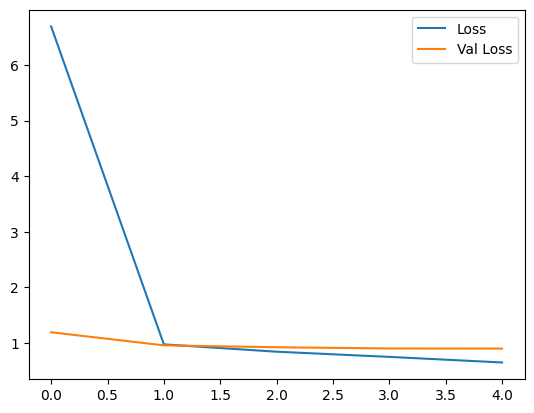

In [13]:
from matplotlib import pyplot as plt

history = model.history.history
plt.plot(history['loss'], label='Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [14]:
test_predictions = model.predict([test_data['user_id'], test_data['item_id']])

user_predictions = {}
for user_id, item_id, rating, prediction in zip(test_data['user_id'], test_data['item_id'], test_data['rating'], test_predictions):
    if user_id not in user_predictions:
        user_predictions[user_id] = []
    user_predictions[user_id].append((item_id, rating, prediction[0]))

for user_id in user_predictions:
    user_predictions[user_id].sort(key=lambda x: x[2], reverse=True)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [15]:
# Calculate Recall@10
recall_at_10 = 0
for user_id in user_predictions:
    top_10_predictions = [item_id for item_id, _, _ in user_predictions[user_id][:10]]
    true_positives = [item_id for item_id, rating, _ in user_predictions[user_id] if rating >= 4]

    if len(true_positives) > 0:
        num_true_positives = len(set(top_10_predictions).intersection(set(true_positives)))
        recall_at_10 += num_true_positives / len(true_positives)

recall_at_10 /= len(user_predictions)

print("Recall@10: {:.4f}".format(recall_at_10))

Recall@10: 0.7216


In [16]:
desired_user_id = 1  # Specify the desired user_id
desired_user_predictions = user_predictions[desired_user_id]
desired_user_predictions.sort(key=lambda x: x[2], reverse=True)

# Get the item_ids of the top 10 recommended movies for the desired user
top_10_movie_ids = [item_id for item_id, _, _ in desired_user_predictions[:10]]

In [17]:
print(f"Recommended Movies For UserID = {desired_user_id} : {top_10_movie_ids}")

Recommended Movies For UserID = 1 : [274, 257, 278, 291, 110, 289, 293, 298]
